In [118]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

import cv2
torch.set_printoptions(precision=10)

from IPython.display import display
from PIL import Image


In [119]:
#load image
true_image = cv2.imread("coloured.jpg")
true_mask = cv2.imread("mask.jpg")
#m3 = cv2.merge((m,m,m))

#preprocess image
transform = transforms.Compose(
    [transforms.ToTensor()
     ])

def inverse_normalization(x):
    x *= 255 
    x = torch.clamp(x, 0, 255)
    #x = x.numpy()
    return x

# print(true_image.shape, true_mask.shape)
# true_image_tensor = torch.from_numpy(true_image).float()
# true_image_tensor = true_image_tensor.permute(2,0,1)
# true_mask_tensor = torch.from_numpy(true_mask).float()
# true_mask_tensor = true_mask_tensor.permute(2,0,1)

input_image = transform(true_image).unsqueeze(0)
gt_image = input_image.clone()
gt_mask = transform(true_mask).unsqueeze(0)
gt_mask = gt_mask.mean(axis=1).unsqueeze(0)
print(input_image.shape, gt_image.shape, gt_mask.shape)
print(input_image.dtype, gt_image.dtype, gt_mask.dtype)

#Normalize 0 to 1

torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64]) torch.Size([1, 1, 64, 64])
torch.float32 torch.float32 torch.float32


In [120]:
input_image.min(), input_image.max()

(tensor(0.), tensor(0.9098039269))

In [121]:
gt_image.min(), gt_image.max()

(tensor(0.), tensor(0.9098039269))

In [122]:
gt_mask.min(), gt_mask.max(), gt_mask.shape

(tensor(0.), tensor(1.), torch.Size([1, 1, 64, 64]))

In [123]:
#true_mask_tensor.min(), true_mask_tensor.max()


In [124]:
class encoder(nn.Module):
        def __init__(self):
                super(encoder, self).__init__()
                self.conv1 = nn.Conv2d(3,64, kernel_size=3)
                self.conv2 = nn.Conv2d(64,32, kernel_size=3)
                self.conv3 = nn.Conv2d(32,16, kernel_size=3)
                
                self.conv1d1 = nn.Conv1d(16*58*58, 1024, kernel_size=1)
                self.conv1d2 = nn.Conv1d(1024,512, kernel_size=1)
                self.conv1d3 = nn.Conv1d(512,256, kernel_size=1)

                self.upconv1 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1)
                self.upconv2 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1)
                self.upconv3 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1)
                
   
        def forward(self,x):
                #Encodings
                x = F.relu(self.conv1(x))
                x = F.relu(self.conv2(x))
                x = F.relu(self.conv3(x))
                #print("X shape", x.shape) # torch.Size([1, 16, 58, 58])
                
                #Style vector
                x_style = torch.flatten(x,1)
                x_style = x_style.unsqueeze(-1)
                x_style = F.relu(self.conv1d1(x_style))
                x_style = F.relu(self.conv1d2(x_style))
                x_style = F.relu(self.conv1d3(x_style))
                #print("Final X_Style: ", x_style.shape)

                #Image 
                x_image = F.relu(self.upconv1(x))
                x_image = F.relu(self.upconv2(x_image))
                x_image = self.upconv3(x_image)
            
#                 x_style = inverse_normalization(x_style)
#                 x_image = inverse_normalization(x_image)
                
#                 x_image = inverse_normalization(x_image)
                
                return x_style, x_image





In [280]:

class decoder(nn.Module):
        def __init__(self):
              super(decoder, self).__init__()
                  
              #Convert style for concat
              self.conv1d0 = nn.Conv1d(256,512, kernel_size=1)

              #Convert image for concat
              self.conv1 = nn.Conv2d(1,64, kernel_size=3)
              self.conv2 = nn.Conv2d(64,32, kernel_size=3)
              self.conv3 = nn.Conv2d(32,16, kernel_size=3)
              self.conv1d1 = nn.Conv1d(16*58*58, 1024, kernel_size=1)
              self.conv1d2 = nn.Conv1d(1024,512, kernel_size=1)

              #Convert image
              self.conv1d3 = nn.Conv1d(1024, 1024, kernel_size=1)
              self.conv1d4 = nn.Conv1d(1024, 1024, kernel_size=1)

              #Using Upsample + Upconv
   
              self.upsample1 = nn.Upsample(scale_factor=2,mode='nearest')
              self.upconv1 = nn.ConvTranspose2d(16, 16, 1, stride=1)
              self.upsample2 = nn.Upsample(scale_factor=2,mode='nearest')
              self.upconv2 = nn.ConvTranspose2d(16, 16, 1, stride=1)              
              self.upsample3 = nn.Upsample(scale_factor=2,mode='nearest')
              self.upconv3 = nn.ConvTranspose2d(16, 3, 1, stride=1)
       
              
                

        def forward(self,x_style,x_image):
              
#               x_image /= 255.0 
              #x_style = torch.from_numpy(x_style)
              #x_image = torch.from_numpy(x_image)
                
              x1 = F.relu(self.conv1d0(x_style)) # 512 style
            
              x2 = F.relu(self.conv1(x_image))
              x2 = F.relu(self.conv2(x2))
              x2 = F.relu(self.conv3(x2))
              x2 = torch.flatten(x2, 1)
              x2 = x2.unsqueeze(-1)
              x2 = F.relu(self.conv1d1(x2))
              x2 = F.relu(self.conv1d2(x2))     # 512 image

              x = torch.cat([x1,x2], dim=1) #Linear concatenate, output = [1,1024]

              x = F.relu(self.conv1d3(x))
              x = F.relu(self.conv1d4(x))
              x = (torch.reshape(x, (16,8,8))).unsqueeze(dim=0)

              x = self.upsample1(x)
              x = F.relu(self.upconv1(x))
              x = self.upsample2(x)
              x = F.relu(self.upconv2(x))
              x = self.upsample3(x)
              x = self.upconv3(x)

#               x = inverse_normalization(x)
            
              return x


In [126]:
class MyModel(nn.Module):
    def __init__(self, enc, dec):
      super(MyModel, self).__init__()
      self.enc = enc
      self.dec = dec

    def forward(self, x):
      style, output_mask = self.enc(x)
      output_img = self.dec(style, output_mask)
      return output_img, output_mask


In [127]:
enc = encoder()
dec = decoder()
model = MyModel(enc,dec)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [129]:
#for g in optimizer.param_groups:
#    g['lr'] = 1e-4


In [166]:

for epoch in range(150,155):
    #Training Encoder
    optimizer.zero_grad() 
    out_image, out_mask = model(input_image)

#     print(out_image.shape, out_mask.shape)
#     print(gt_image.shape, gt_mask.shape)
#     print(out_image.dtype, out_mask.dtype)
#     print(gt_image.dtype, gt_mask.dtype)

    loss_mask = criterion(out_mask.squeeze(0), gt_mask)
    loss_style = criterion(out_image.squeeze(0), gt_image)
    total_loss = loss_mask + loss_style

#     print(total_loss.item())
#     if epoch % 5 == 0:
#     print("Epoch:", epoch, " Loss_mask: {:.3f} Loss style: {:.3f} ".format(loss_mask.item(), loss_style.item()))
    print(f'Epoch = {epoch} | loss_total = {total_loss.item():.3f} , loss_mask = {loss_mask.item():.3f}, loss_style = {loss_style.item():.3f}')

    total_loss.backward()
    optimizer.step()



Epoch = 150 | loss_total = 0.090 , loss_mask = 0.004, loss_style = 0.086
Epoch = 151 | loss_total = 0.089 , loss_mask = 0.004, loss_style = 0.086
Epoch = 152 | loss_total = 0.089 , loss_mask = 0.004, loss_style = 0.085
Epoch = 153 | loss_total = 0.088 , loss_mask = 0.004, loss_style = 0.085
Epoch = 154 | loss_total = 0.088 , loss_mask = 0.004, loss_style = 0.084


In [270]:
out_image, out_mask = model(input_image)
out_image, out_mask = out_image.detach(), out_mask.detach()
out_image, out_mask = torch.clamp(out_image, 0, 1), torch.clamp(out_mask, 0, 1)
# out_image = (out_image - out_image.min()) / (out_image.max() - out_image.min())
# out_mask = (out_mask - out_mask.min()) / (out_mask.max() - out_mask.min())

In [271]:
out_image.min(), out_image.max(), out_mask.min(), out_mask.max()

(tensor(0.), tensor(0.7761616707), tensor(0.), tensor(1.))

In [272]:
#out_image = out_image.squeeze() * 255
#out_mask = out_mask.squeeze() * 255

In [273]:
gt_image.squeeze().shape, gt_image.dtype

(torch.Size([3, 64, 64]), torch.float32)

In [274]:
out_image.squeeze().shape, out_image.dtype

(torch.Size([3, 64, 64]), torch.float32)

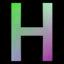

In [275]:
transforms.ToPILImage()(gt_image.squeeze())

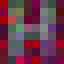

In [276]:
transforms.ToPILImage()(out_image.squeeze())

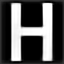

In [277]:
transforms.ToPILImage()(out_mask.squeeze())

In [22]:
#Convert tensors to images

result_image = transforms.ToPILImage()(output_image.squeeze(0))
result_mask = transforms.ToPILImage()(output_mask.squeeze(0))
original_mask = transforms.ToPILImage()(true_mask.squeeze(0))
original_image = transforms.ToPILImage()(true_image.squeeze(0))

NameError: name 'output_image' is not defined